# Simulation and Control of an Exothermic Continuous Stirred Tank Reactor

###### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/Exothermic-Reactor](http://github.com/jckantor/Ball-and-Beam)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

Jeffrey C. Kantor (Kantor.1@nd.edu)

This Jupyter notebook demonstrates the simulation and control of an exothermic continuous stirred-tank reactor (CSTR). The ultimate task is to design a feedback control system to maintain the reactor at a desired steady setpoint at high conversion with the termperature below an specified operating limit. The task is challenging because of the strong nonlinear coupling of reaction rate to temperature.

<img align="center" src="reactor_fig.png" alt="Exothermic Reactor" title="Exothermic Reactor" width="480">

Everything is included in a single, self-contained Jupyter notebook using standard python libraries.

### Table of Contents

* [Initialization](#Initialization). 
* [Modeling of an Exothermic CSTR](#Modeling of an Exothermic CSTR).
* [Simulation](#Simulation). 
* [Simulation and Phase Plane Analysis](#Simulation and Phase Plane Analysis).


### How to Use

The simplest way to use this notebook is to run it in the cloud. This can be done from any browser (laptop, tablet, phone), and doesn't require any software installation. Click this button to get started:

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/jckantor/Exothermic-Reactor)

Alternatively the notebook can be downloaded to your laptop and run as a standard Jupyter notebook. This requires prior installation of a Python 2.7 distribution with standard libraries such as [Anaconda](https://www.continuum.io/) available from Continuum Analytics, or [Canopy](https://www.enthought.com/) available from Enthought, Inc.

Once the notebook is loaded in an executable environment, either in the cloud or laptop, proceed through the notebook executing each cell, one at a time. You can use either the `run` button in the Jupyter tool bar, or press `shift-enter` for each cell. 

<a id="initialization"></a>
## Initialization (Run this cell first!)

Be sure to run the Initialization cell first! This sets up the graphical backend to display plots and widgets within the notebook, and loads required python libraries.

In [1]:
%matplotlib notebook

from pylab import *
from scipy.integrate import odeint

<a id="Modeling of an Exothermic CSTR"></a>
## Modeling of an Exothermic CSTR

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).


### Model Equations

\begin{align*}
V\frac{dC}{dt} & = q(C_f - C)-Vk(T)C \\
V\rho C_p\frac{dT}{dt} & = \rho q C_p(T_f - T) + (-\Delta H_R)Vk(T)C + UA(T_c - T)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c_A$ and $T$ give

\begin{align*}
\frac{dC}{dt} & = \frac{q}{V}(C_f - C)- k(T)C \\
\frac{dT}{dt} & = \frac{q}{V}(T_f - T) + \frac{-\Delta H_R}{\rho C_p}k(T)C + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}

where $k(T)$ is given by the Arrhenius equation

$$k(T) = k_0 \exp(-\frac{E}{RT})$$

which are the equations that will be integrated below.

<a id="Simulation"></a>
## Simulation

### Simulaton Model

In [2]:
def k(T):
    return k0*exp(-ER/T)

def deriv(y,t):
    C,T = y
    dC = (q/V)*(Cf - C) - k(T)*C
    dT = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*C + (UA/V/rho/Cp)*(Tc-T)
    return [dC,dT]

### Parameter Values

The following values are from SEMD, Table 2.3.

In [3]:
q = 100.0          # Flowrate [L/min]
Cf = 1.0           # Inlet feed concentration [mol/L]
Tf  = 350.0        # Inlet feed temperature [K]
V   = 100.0        # Volume [L]
rho = 1000.0       # Density [g/L]
Cp   = 0.239       # Heat capacity [J/g/K]
dHr = -5.0e4       # Heat of reaction [J/mol]

ER  = 8750.0       # Ea/R [K]
k0  = 7.2e10       # Arrhenius rate constant
UA  = 5.0e4        # Heat transfer [J/min/K]

### Simulation Code

<IPython.core.display.Javascript object>


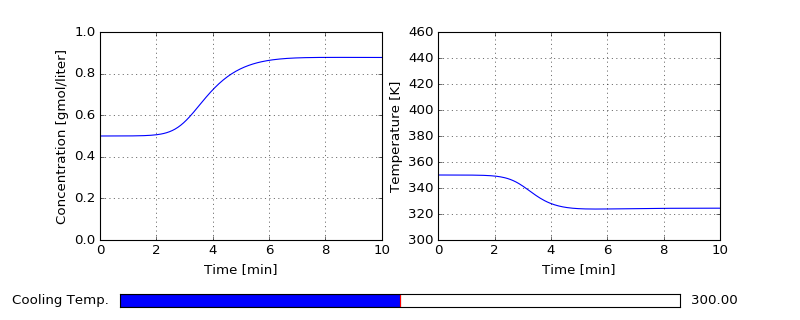

In [4]:
Ci = 0.5;      # Initial concentration [mol/L]
Ti  = 350.0;    # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]

# Time Grid
dt = 0.05
tf = 10.0
t = linspace(0,tf,tf/dt)

# Solution. The transpose unpacks the result into independent states
[C,T] = odeint(deriv,[Ci,Ti],t).T

# Set up plotting axes
fig,ax = subplots(1,2,figsize=(10,4))

# Plot simulation results. Save lines for updating
cline, = ax[0].plot(t,C)
ax[0].set(ylim=(0,1),xlabel='Time [min]',ylabel='Concentration [gmol/liter]')
ax[0].grid()
tline, = ax[1].plot(t,T)
ax[1].set(ylim=(300.0,460.0),xlabel='Time [min]',ylabel='Temperature [K]')
ax[1].grid()

# Setup Slider Widget
def update(val):
    global Tc
    Tc = s_Tc.val
    [C,T] = odeint(deriv,[Ci,Ti],t).T
    cline.set_ydata(C)
    tline.set_ydata(T)

subplots_adjust(bottom=0.25)
s_Tc = Slider(axes([0.15, 0.04, .7, 0.04]), 'Cooling Temp.', 290.0, 310.0, valinit=Tc)
s_Tc.on_changed(update);

<a id="Simulation and Phase Plane Analysis"></a>
## Simulation and Phase Plane Analysis

Our goal here is to create an interactive phase plane simulation that can be used to study the dependence of reactor dynamics on cooling temperature and initial conditions.

\begin{align}
\frac{dC}{dt} = 0 & \implies C = \frac{q C_f}{q + V k(T)} \\
\\
\frac{dT}{dt} = 0 & \implies C = \frac{\rho q C_p(T_f - T) + UA(T_c - T)}{-\Delta H_R V k(T)}
\end{align}

<IPython.core.display.Javascript object>


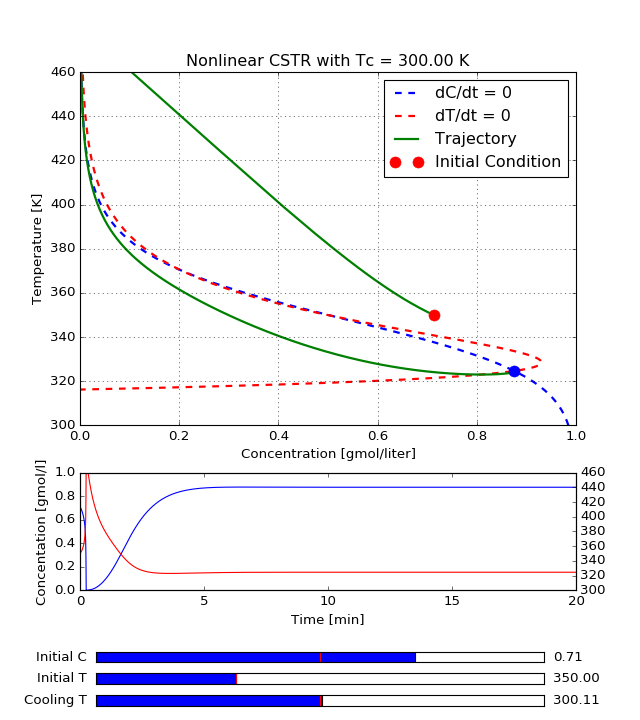

In [5]:
Ci = 0.5;       # Initial concentration [mol/L]
Ti = 350.0;     # Initial temperature [K]
Tc = 300.0      # Coolant temperature [K]

# Time Grid
dt = 0.01
tf = 20.0
t = linspace(0,tf,tf/dt)

# Solve for steady state
from scipy.optimize import fsolve

def f(x):
    return deriv(x,0.0)

# Solution. The transpose unpacks the result into independent states
[C,T] = odeint(deriv,[Ci,Ti],t).T
[Css,Tss] = fsolve(f,[C[-1],T[-1]])

# Set up plotting axes
fig = figure(figsize=(8,9))
gs = GridSpec(2,1, height_ratios=[3, 1]) 
pplot = subplot(gs[0])   # phase plot axis
cplot = subplot(gs[1])   # concentration plot axis
tplot = cplot.twinx()    # temperature plot axis

pplot.set_title('Nonlinear CSTR with Tc = {0:6.2f} K'.format(Tc))
pplot.set(xlabel='Concentration [gmol/liter]',ylabel='Temperature [K]')
pplot.set(xlim=(0,1.0), ylim=(300,460))
pplot.grid()
cplot.set(xlim=(0,tf),ylim=(0,1.0),xlabel='Time [min]', ylabel = 'Concentation [gmol/l]')
tplot.set(xlim=(0,tf),ylim=(300.0,460.0))

# calculate nullclines
def cnull(T):
    return q*Cf/(q + V*k(T))

def tnull(T):
    return (rho*q*Cp*(Tgrid-Tf) + UA*(Tgrid-Tc))/(-dHr*V*k(Tgrid))

Tgrid = linspace(300.0,460.0,1000)
cnull_line, = pplot.plot(cnull(Tgrid),Tgrid,'b--',lw=2)
tnull_line, = pplot.plot(tnull(Tgrid), Tgrid,'r--',lw=2)
traj, = pplot.plot(C,T,'g',lw=2)
ic, = pplot.plot(Ci,Ti,'r.',ms=20)
ss, = pplot.plot(Css,Tss,'b.',ms=20)
pplot.legend(['dC/dt = 0','dT/dt = 0','Trajectory','Initial Condition'])
cline, = cplot.plot(t,C,'b')
tline, = tplot.plot(t,T,'r')

# position sliders
subplots_adjust(bottom=0.18)
s_Ci = Slider(axes([0.15, 0.08, 0.7, 0.015]), 'Initial C', 0.0, 1.0, valinit=Ci)
s_Ti = Slider(axes([0.15, 0.05, 0.7, 0.015]), 'Initial T', 300.0, 460.0, valinit=Ti)
s_Tc = Slider(axes([0.15, 0.02, 0.7, 0.015]), 'Cooling T', 290.0, 310.0, valinit=Tc)

# callback function to update plots
def update(val):
    global Tc
    Tc = s_Tc.val
    [C,T] = odeint(deriv,[s_Ci.val,s_Ti.val],t).T
    [Css,Tss] = fsolve(f,[C[-1],T[-1]])
    ic.set(xdata=s_Ci.val, ydata=s_Ti.val)
    ss.set(xdata=Css, ydata=Tss)
    traj.set(xdata=C,ydata=T)
    cline.set(ydata=C)
    tline.set(ydata=T)
    tnull_line.set_xdata(tnull(Tgrid))

s_Ci.on_changed(update);
s_Ti.on_changed(update);
s_Tc.on_changed(update);

## Work in Progress

This notebook is not complete. The following cells represent work in progress that will typically be broken and non-functional at any point in time.

In [ ]:
Tc = 298.0
def f(T):
    return cnull(T)-tnull(T)

figure(figsize=(8,6))
plot(Tgrid,f(Tgrid))
ylim(-0.1,0.1)
grid()

In [ ]:
# Cooling Temperature
Tc = 305

# Initial Guess for the Steady State
cA = 0.5
T = 380.0

# Solve for steady state
from scipy.optimize import fsolve

def f(x):
    return deriv(x,0.0)

[cA_ss,T_ss] = fsolve(f,[cA,T])

print "Steady State:"
print "   cA = ", cA_ss, "gmol/liter"
print "    T = ", T_ss, "K"

## Steady States

## Linearization


\begin{align*}
\frac{\partial f_1}{\partial c_A} & = -\frac{q}{V} - k(T) \\
\frac{\partial f_1}{\partial T} & = -\frac{\partial k}{\partial T} c_A \\
\frac{\partial f_2}{\partial c_A} & = \frac{-\Delta H_r}{\rho C_p} k(T)\\
\frac{\partial f_2}{\partial T} & = -\frac{q}{V} + \frac{-\Delta H_r}{\rho C_p} \frac{\partial k}{\partial T} c_A -  \frac{UA}{\rho C_p V}
\end{align*}

Where the derivative of Arrehenius law with respect to temperature is given by the chain rule

$$\frac{\partial k}{\partial T} = \frac{E}{RT^2}k_0e^{-\frac{E}{RT}} = \frac{E}{RT^2}k(T)$$

$$A = \left[\begin{array}{cc} 
-\frac{q}{V} - k(T) & 
-\frac{\partial k}{\partial T} c_A \\
\frac{-\Delta H_r}{\rho C_p} k(T) &
-\frac{q}{V} + \frac{-\Delta H_r}{\rho C_p} \frac{\partial k}{\partial T} c_A -  \frac{UA}{\rho C_p V}
\end{array}\right]$$

In [ ]:
A = array([[-q/V - k(T_ss), -(ER/T_ss/T_ss)*k(T_ss)*cA_ss],
     [(-dHr/rho/Cp)*k(T_ss), -q/V - (UA/V/rho/Cp) + (-dHr/rho/Cp)*(ER/T_ss/T_ss)*k(T_ss)*cA_ss]])

B = array([[0.0],[UA/V/rho/Cp]])

C = array([[0.0, 1.0]])

D = array([[0.0]])

print "A = ", A
print "B = ", B
print "C = ", C
print "D = ", D

In [ ]:
evals,evecs = eig(A)
print evals

In [ ]:

def deriv_lin(x,t):
    return dot(A,x) 

t = linspace(0,10,1000)

y = odeint(deriv,[0.15,380],t)
cA = y[:,0]
T = y[:,1]


plot(t,cA)
